# MUSIC Super-resolution Microscopy

## Dependencies

In [478]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D

## Program Parameters

In [479]:
class params:
    k     = 3       # Source number
    M     = 24      # Sensor array size (assuming square)
    T     = 200     # Snapshot number
    noise = 0.01       # Noise power
    width = 1       # Sensors are placed between [-width,width]
    sep   = 0.2    # Source inter-separation distance
    sig   = 0.05       # Gaussian kernel variance
    Q     = 128      # MUSIC 'Resolution'
p = params()

## Creating Synthetic Data

$$[U]_{s,k} = u(r_s-r_k) = \exp(-\frac{1}{2\sigma}\| r_s-r_k \|^2) $$

### Plot 1D Gaussian Kernel (for viewing)

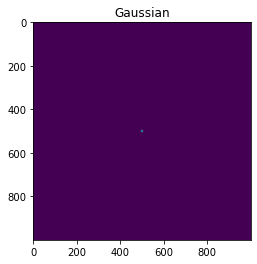

In [480]:
# Plot the 1D Kernel 
x = np.linspace(-10,10,1000).reshape(-1,1)
gx = np.exp(-(0.5/p.sig**2)*np.abs(x)**2)
gy = np.exp(-(0.5/p.sig**2)*np.abs(x)**2)
g  = gx @ gy.T
plt.imshow(g)
plt.title('Gaussian')
plt.show()

### Create Synthetic Measurement Data

In [481]:
#https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]

#### (a) Create Diagonals

In [482]:
# Generate diagonal 2D source positions
r_kx = np.linspace(-p.sep*p.width,p.sep*p.width,p.k).reshape(-1,1)
r_ky = np.linspace(-p.sep*p.width,p.sep*p.width,p.k).reshape(-1,1)
r_k  = np.hstack((r_kx,r_ky))

# Create High-resolution image representation of source positions
hr_sx = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)
hr_sy = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)

truth_img = np.zeros((p.Q,p.Q))
for x,y in r_k:
    indx,_ = find_nearest(hr_sx,x)
    indy,_ = find_nearest(hr_sy,y)
    truth_img[indx,indy] = 1

#### (b) or Get from Image

In [483]:
# Generate 2D source positions from image
img = plt.imread("strands1.tif")

# Get HR grid size from image instead
p.Q = img.shape[0]

# Create that HR grid w/ proper distances
hr_sx = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)
hr_sy = np.linspace(-p.width,p.width,p.Q).reshape(-1,1)

# Get non-zero indicies from truth
r_ind = np.asarray(np.nonzero(img.T)).T

# Get number of sources
p.k = r_ind.shape[0]

# Convert it to distances, and finalize r_k
r_kx = hr_sx[r_ind[:,0]]
r_ky = hr_sy[r_ind[:,1]]
r_k  = np.hstack((r_kx,r_ky))

# Assign truth to proper variable
truth_img = img

In [484]:
# Create 2D (low-resolution) measurement array
r_sx = np.linspace(-p.width,p.width,p.M).reshape(-1,1)
r_sy = np.linspace(-p.width,p.width,p.M).reshape(-1,1)
r_s  = np.hstack((r_sx,r_sy))

# From source positions, and the sensors, create the sensing matrix
U = np.zeros((p.M**2,p.k))
for k in range(p.k):
    r  = r_k[k]
    arg = r_s - r
    uflat = np.exp(-(0.5/p.sig**2)*np.abs(arg)**2)
    ux = uflat[:,0].reshape(-1,1)
    uy = uflat[:,1].reshape(-1,1)
    Uk = ux @ uy.T.conj()
    U[:,k] = Uk.flatten('F')

# Construct random flucations over frames for the sources
x = np.random.uniform(0,2,(p.k,p.T));
# Construct additive noise (clip if less than 0)
n = p.noise*np.random.randn(p.M**2,p.T)
n[np.where(n < 0)] = 0

# Construct final measurements
f = U @ x + n

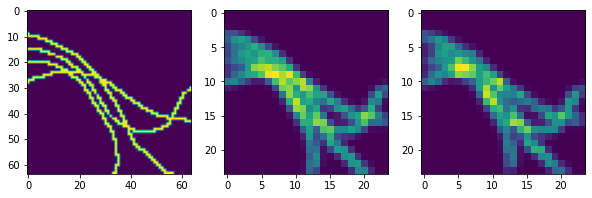

371 Sources


In [485]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(truth_img)
plt.subplot(1,3,2)
plt.imshow(np.mean(f,axis=1).reshape(-1,p.M))
plt.subplot(1,3,3)
plt.imshow(f[:,np.random.randint(p.M)].reshape(-1,p.M))

plt.show()
print("{} Sources".format(p.k))

## Perform MUSIC to recover sources

In [486]:
def MUSIC1D(data, sensor_pos, source_num, width, sig, HR_grid_size):
    # Perform SVD on the data
    U,_,_ = np.linalg.svd(data)
    # Select columns of U which correspond to noise-subspace
    U2 = U[:,source_num:]
    # Create Grid for MUSIC
    HR_sensor_pos = np.linspace(-width,width,HR_grid_size)
    # Create HR sensing matrix
    A = np.exp(-(0.5/p.sig**2)*np.abs(sensor_pos[:,np.newaxis] - HR_sensor_pos)**2)
    # Calculate error between sensor image and projection, and invert for MUSIC result
    #err = np.linalg.norm( A - U2 @ U2.conj().T @ A, axis=0 )**2
    music = np.zeros(HR_grid_size)
    for i in range(HR_grid_size):
        err = A[:,i].T.conj() @ (U2@U2.T.conj()) @ A[:,i]
        music[i] = 1/err
    
    return HR_sensor_pos,music

def MUSIC2D(data, sensor_pos, source_num, width, sig, HR_grid_size):
    # Perform SVD on the data
    U,_,_ = np.linalg.svd(data)
    # Select columns of U which correspond to noise-subspace
    U2 = U[:,source_num:]
    # Create Grid for MUSIC
    HR_sensor_pos_x = np.linspace(-width,width,HR_grid_size).reshape(-1,1)
    HR_sensor_pos_y = np.linspace(-width,width,HR_grid_size).reshape(-1,1)
    # Elaborate way to get all combinations of x,y points on the grid
    HR_sensor_pos   = np.stack(np.meshgrid(HR_sensor_pos_x,HR_sensor_pos_y),-1).reshape(-1,2)
    
    # Create HR sensing matrix
    A = np.zeros((sensor_pos.shape[0]**2,HR_grid_size**2))
    for q in range(HR_grid_size**2):
        r  = HR_sensor_pos[q,:]
        arg = sensor_pos - r
        aflat = np.exp(-(0.5/p.sig**2)*np.abs(arg)**2)
        ax = aflat[:,0].reshape(-1,1)
        ay = aflat[:,1].reshape(-1,1)
        Aq = ax @ ay.T.conj()
        A[:,q] = Aq.flatten('F')

    # Calculate error between sensor image and projection, and invert for MUSIC result
    
    music = np.zeros(HR_grid_size**2)
    for i in range(HR_grid_size**2):
        err = A[:,i].T.conj() @ (U2@U2.T.conj()) @ A[:,i]
        #err = np.linalg.norm( A[:,i] - U2 @ U2.conj().T @ A[:,i] )**2
        music[i] = 1/err
    
    return HR_sensor_pos,music

music_axis, music = MUSIC2D(f,r_s,p.k,p.width,p.sig,p.Q)

## Display Results

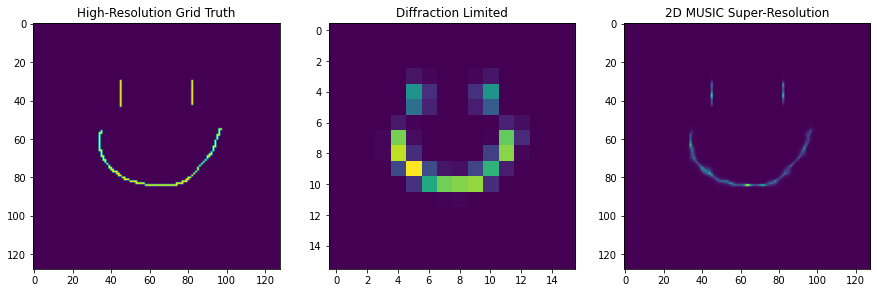

Normalized MSE: 4567.9069172787695


In [472]:
plt.figure(figsize=(15,5))

p1 = plt.subplot(1,3,1)
plt.imshow(truth_img)
plt.title("High-Resolution Grid Truth")

p2 = plt.subplot(1,3,2)
dif_img = np.mean(f,axis=1).reshape(-1,p.M)
plt.imshow(dif_img)
plt.title("Diffraction Limited")

p2 = plt.subplot(1,3,3)
music_img = music.reshape(p.Q,p.Q)
plt.imshow(music_img)
plt.title("2D MUSIC Super-Resolution")

plt.show()


print("Normalized MSE: {}".format((np.square(np.subtract(music_img, truth_img)).mean()*(1/p.Q)**2)))